In [9]:
from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

from settings import TOTALLY_NOT_A_PARSER


from custom_module import parse_yf_esg, get_tickers, parse_mc


# Введение

### Что мы вообще хотим?

Мы хотим провести анализ esg-рейтинга фирм и то, насколько вообще это влияет на финансовые показатели фирмы.

Если взаимосвязь есть - попытаться предсказать поведение фирмы в кризисе и вне кризиса, основываясь на esg рисках

### Гипотезы

1. Финансовые показатели положительно зависят от esg-рисков

2. Фирмы с низкими esg показателями хуже справляются с кризисами

# Часть первая: Сбор данных

Для сбора данных нам необходимо для начала получить максимально возможное количество тикеров. Самая большая бесплатная база данных, которую мы нашли, это файл на сайте https://www.nasdaq.com/market-activity/stocks/screener
Далее необходимо собрать все необходимые данные: значения оценок esg рисков, прибыль по годам, цены на акции и прочие. Для этого мы парсили сайты Yahoo Finance и Market Cap


### Парсинг

In [ ]:
tickers = get_tickers()
df_esg = pd.DataFrame(parse_yf_esg(), index=tickers)
df_true_esg = df_esg[df_esg['Environment Risk Score'].notna()]
df_fins = pd.DataFrame(parse_mc(df_true_esg['Symbol']))

In [7]:
df_true_esg = pd.read_csv('true_esg.csv')

In [ ]:
df_fins = pd.DataFrame(parse_mc(df_true_esg['Symbol'])[0])

In [ ]:
df_fins.to_csv('financials.csv')

### Данные

In [104]:
df_esg = pd.read_csv('true_esg.csv')
df_fin = pd.read_csv('financials.csv').drop('Unnamed: 0', axis=1)

In [105]:
df_esg_corr = df_esg
df_esg_corr['rise'] = (df_fin['Чистая прибыль 2020']-df_fin['Чистая прибыль 2019'])/df_fin['Чистая прибыль 2019']
df_esg_corr['sum'] = df_esg['Environment Risk Score'] + df_esg['Social Risk Score'] + df_esg['Governance Risk Score']

In [106]:
df_esg_full_corr = df_esg_corr.merge(df_fin, on='Symbol')

### EDA

2019: Медианная прибыль - 854000000, Медианная капитализация - 19100000000
2020: Медианная прибыль - 603000000, Медианная капитализация - 19550000000
2019: Медианная прибыль - 1010000000, Медианная капитализация - 25100000000


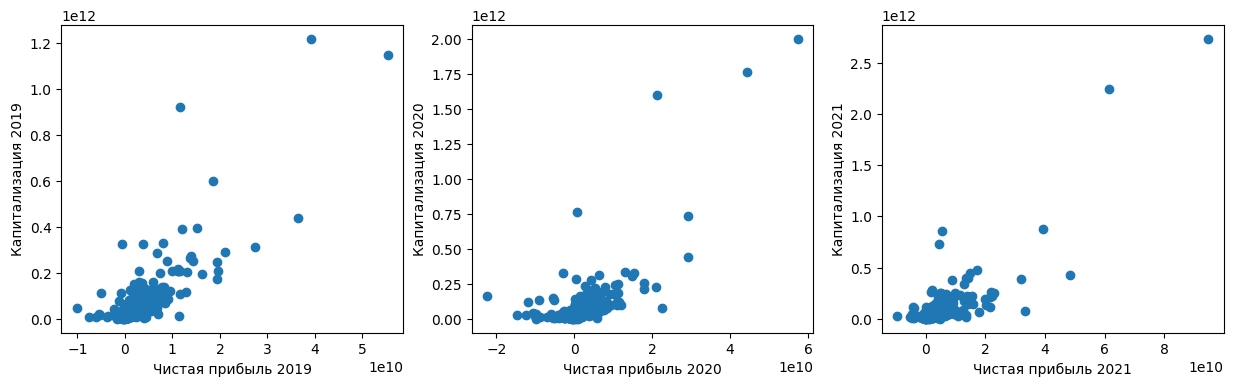

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.scatter(df_fin['Чистая прибыль 2019'], df_fin['Капитализация 2019'])
ax1.set_xlabel('Чистая прибыль 2019')
ax1.set_ylabel('Капитализация 2019')
ax2.scatter(df_fin['Чистая прибыль 2020'], df_fin['Капитализация 2020'])
ax2.set_xlabel('Чистая прибыль 2020')
ax2.set_ylabel('Капитализация 2020')
ax3.scatter(df_fin['Чистая прибыль 2021'], df_fin['Капитализация 2021'])
ax3.set_xlabel('Чистая прибыль 2021')
ax3.set_ylabel('Капитализация 2021')
print(f"2019: Медианная прибыль - {int(df_fin['Чистая прибыль 2019'].median())}, Медианная капитализация - {int(df_fin['Капитализация 2019'].median())}")
print(f"2020: Медианная прибыль - {int(df_fin['Чистая прибыль 2020'].median())}, Медианная капитализация - {int(df_fin['Капитализация 2020'].median())}")
print(f"2019: Медианная прибыль - {int(df_fin['Чистая прибыль 2021'].median())}, Медианная капитализация - {int(df_fin['Капитализация 2021'].median())}")

Видно, что выбросов во время кризиса стало больше, прибыль снизилась, но как ни странно, капитализация не упала.

# Часть вторая: Анализ данных

In [113]:
c_s = df_esg_corr[df_esg_corr['rise']<0.5]['rise'].corr(df_esg_corr[df_esg_corr['rise']<0.5]['Social Risk Score'])
g_s = df_esg_corr[df_esg_corr['rise']<0.5]['rise'].corr(df_esg_corr[df_esg_corr['rise']<0.5]['Governance Risk Score'])
e_s = df_esg_corr[df_esg_corr['rise']<0.5]['rise'].corr(df_esg_corr[df_esg_corr['rise']<0.5]['Environment Risk Score'])
print(f'Корреляция Social risks с изменением прибыли - {c_s}')
print(f'Корреляция Governance risks с изменением прибыли - {g_s}')
print(f'Корреляция Environment risks с изменением прибыли - {e_s}')

Корреляция Social risks с изменением прибыли - -0.10317223369436693
Корреляция Governance risks с изменением прибыли - -0.013688727311139324
Корреляция Environment risks с изменением прибыли - -0.03743596156380597


In [109]:
c_s = df_esg_full_corr['Чистая прибыль 2019'].corr(df_esg_full_corr['Social Risk Score'])
g_s = df_esg_full_corr['Чистая прибыль 2019'].corr(df_esg_full_corr['Governance Risk Score'])
e_s = df_esg_full_corr['Чистая прибыль 2019'].corr(df_esg_full_corr['Environment Risk Score'])
print(f'Корреляция Social risks с прибылью за 2019 - {c_s}')
print(f'Корреляция Governance risks с прибылью за 2019 - {g_s}')
print(f'Корреляция Environment risks с прибылью за 2019 - {e_s}')

Корреляция Social risks с изменением прибыли - 0.13171094532116484
Корреляция Governance risks с изменением прибыли - 0.1728488809545267
Корреляция Environment risks с изменением прибыли - -0.14001172022591984


In [112]:
c_s = df_esg_full_corr['Чистая прибыль 2020'].corr(df_esg_full_corr['Social Risk Score'])
g_s = df_esg_full_corr['Чистая прибыль 2020'].corr(df_esg_full_corr['Governance Risk Score'])
e_s = df_esg_full_corr['Чистая прибыль 2020'].corr(df_esg_full_corr['Environment Risk Score'])
print(f'Корреляция Social risks с прибылью за 2020 - {c_s}')
print(f'Корреляция Governance risks с прибылью за 2020 - {g_s}')
print(f'Корреляция Environment risks с прибылью за 2020 - {e_s}')

Корреляция Social risks с прибылью за 2020 - 0.08868684085199441
Корреляция Governance risks с прибылью за 2020 - 0.11926594299670894
Корреляция Environment risks с прибылью за 2020 - -0.22908907241104284


In [111]:
c_s = df_esg_full_corr['Чистая прибыль 2021'].corr(df_esg_full_corr['Social Risk Score'])
g_s = df_esg_full_corr['Чистая прибыль 2021'].corr(df_esg_full_corr['Governance Risk Score'])
e_s = df_esg_full_corr['Чистая прибыль 2021'].corr(df_esg_full_corr['Environment Risk Score'])
print(f'Корреляция Social risks с прибылью за 2021 - {c_s}')
print(f'Корреляция Governance risks с прибылью за 2021 - {g_s}')
print(f'Корреляция Environment risks с прибылью за 2021 - {e_s}')

Корреляция Social risks с изменением прибыли - 0.13582965103677622
Корреляция Governance risks с изменением прибыли - 0.1933143825478231
Корреляция Environment risks с изменением прибыли - -0.10148589253865666


В итоге мы получаем следующие факты:

1. В целом esg риски слабо коррелируют с финансовыми показателями, значит наша первоначальная гипотеза провалилась

2. Подверженность рискам вообще никак не сказывается на том, как компания переживает кризис.

3. Несмотря на слабую зависимость, она везде стабильно отрицательная для рисков окружающей среды. Это можно объяснить тем, что сейчас забота о климате невыгодна для фирм, ведь зелёная энергия дороже, чем обычные энергоносители, а сокращение выбросов ведёт к утяжелению и удорожанию производства продукции.

# Часть третья: Итог

Увы, построение модели не увенчалось успехом. На таком примитивном уровне заметить закономерность не получается, нужен более широкий инструментарий и данные.

### НО

Эта неудача только подтверждает неочевидность ответа на вопрос, влияют ли показатели ESG на устойчивость фирмы во время кризиса.